In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
import shap

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

# Load the dataset
df = pd.read_csv('german_credit_data.csv', index_col=0)

In [4]:
# Display basic info
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 78.1+ KB
None

First 5 rows:
   Age     Sex  Job Housing Saving accounts Checking account  Credit amount   
0   67    male    2     own             NaN           little           1169  \
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little              NaN           2

In [5]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64


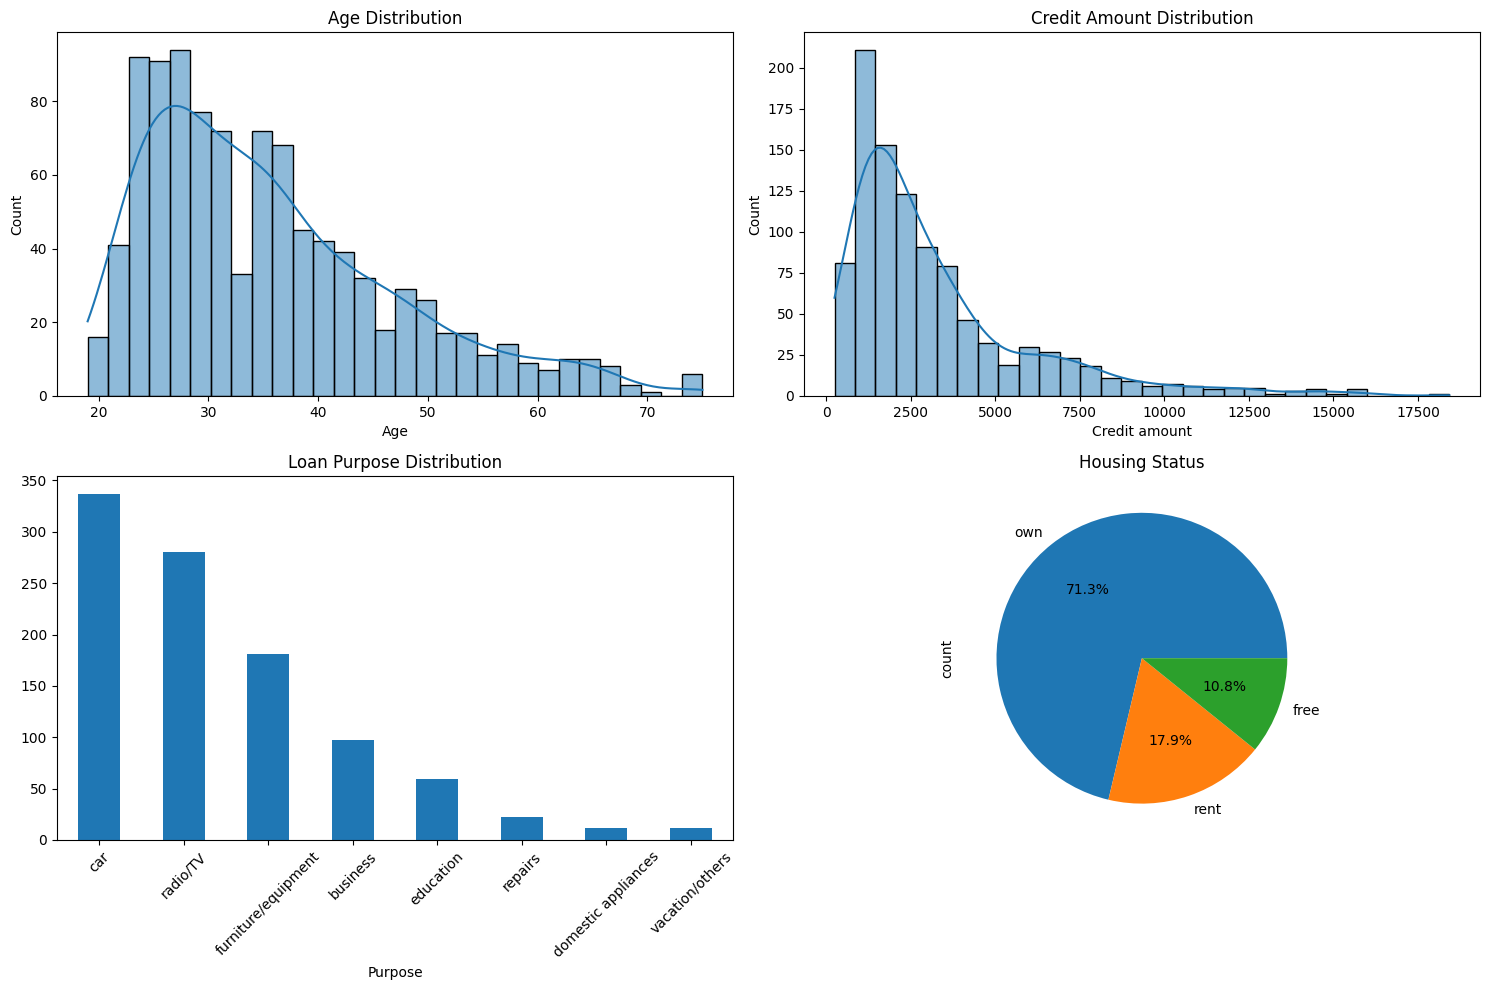

In [6]:
# EDA - Visualizations
plt.figure(figsize=(15, 10))

# Age distribution
plt.subplot(2, 2, 1)
sns.histplot(df['Age'], bins=30, kde=True)
plt.title('Age Distribution')

# Credit amount distribution
plt.subplot(2, 2, 2)
sns.histplot(df['Credit amount'], bins=30, kde=True)
plt.title('Credit Amount Distribution')

# Purpose counts
plt.subplot(2, 2, 3)
df['Purpose'].value_counts().plot(kind='bar')
plt.title('Loan Purpose Distribution')
plt.xticks(rotation=45)

# Housing status
plt.subplot(2, 2, 4)
df['Housing'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Housing Status')

plt.tight_layout()
plt.show()

In [7]:
# Feature Engineering and Preprocessing

# Create target variable - we'll assume credit risk based on credit amount and duration
# Higher credit amount and longer duration are considered higher risk
# This is a simplification - in a real scenario, we'd have actual risk labels
df['CreditRisk'] = np.where(
    (df['Credit amount'] > df['Credit amount'].median()) & 
    (df['Duration'] > df['Duration'].median()), 
    1,  # High risk
    0   # Low risk
)
# Check class balance
print("\nClass distribution:")
print(df['CreditRisk'].value_counts(normalize=True))


Class distribution:
CreditRisk
0    0.65
1    0.35
Name: proportion, dtype: float64


In [8]:
# Define features and target
X = df.drop('CreditRisk', axis=1)
y = df['CreditRisk']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Preprocessing pipeline
numeric_features = ['Age', 'Job', 'Credit amount', 'Duration']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [9]:
# Create individual pipelines for each classifier with its specific params
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Define parameter grids for each classifier
param_grid = [
    {
        'feature_selection__k': [5, 10, 15],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 5, 10],
        'classifier': [RandomForestClassifier(random_state=42)]
    },
    {
        'feature_selection__k': [5, 10, 15],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 5, 7],
        'classifier': [GradientBoostingClassifier(random_state=42)]
    },
    {
        'feature_selection__k': [5, 10, 15],
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier': [LogisticRegression(max_iter=1000, random_state=42)]
    }
]

# Perform grid search using the common base pipeline (any of the above)
grid_search = GridSearchCV(pipeline_rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print("\nBest parameters found:")
print(grid_search.best_params_)

# Evaluate on test set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))

Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters found:
{'classifier': RandomForestClassifier(random_state=42), 'classifier__max_depth': None, 'classifier__n_estimators': 100, 'feature_selection__k': 5}

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       195
           1       1.00      1.00      1.00       105

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300


Confusion Matrix:
[[195   0]
 [  0 105]]

ROC AUC Score: 1.0


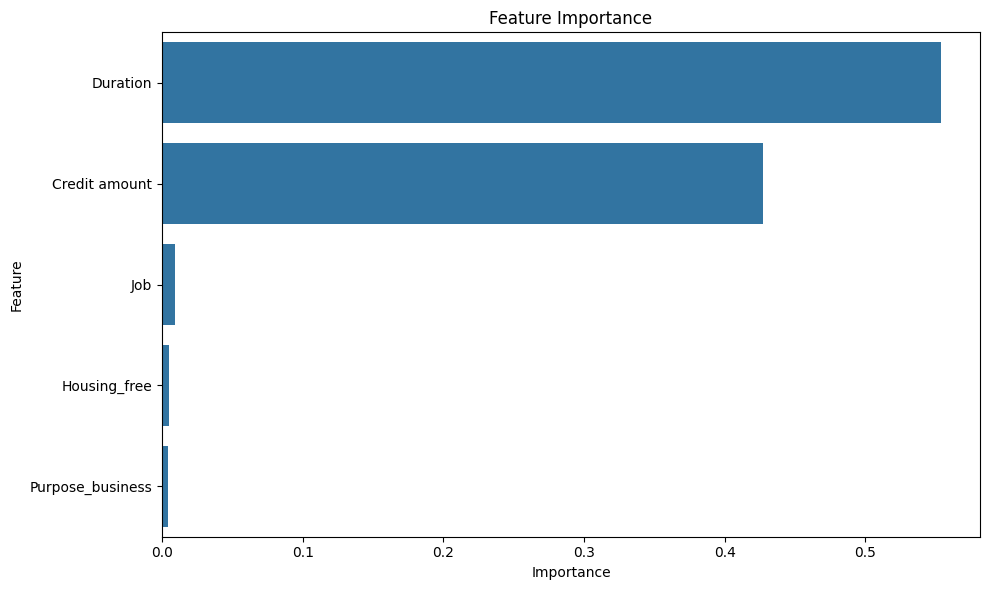

In [10]:
# Feature Importance
# Get feature names after preprocessing
preprocessor.fit(X_train)
feature_names = numeric_features + list(
    best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))
    
selected_features = best_model.named_steps['feature_selection'].get_support()
selected_feature_names = [f for f, s in zip(feature_names, selected_features) if s]

if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    importances = best_model.named_steps['classifier'].feature_importances_
    feature_importance = pd.DataFrame({'Feature': selected_feature_names, 'Importance': importances})
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()
elif hasattr(best_model.named_steps['classifier'], 'coef_'):
    coef = best_model.named_steps['classifier'].coef_[0]
    feature_importance = pd.DataFrame({'Feature': selected_feature_names, 'Coefficient': coef})
    feature_importance = feature_importance.sort_values('Coefficient', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=feature_importance)
    plt.title('Feature Coefficients')
    plt.tight_layout()
    plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_15296\3710478406.py:54: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, selected_X_train, feature_names=selected_feature_names, plot_type="bar")
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\shap\plots\_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\shap\plots\_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to t

<Figure size 640x480 with 0 Axes>

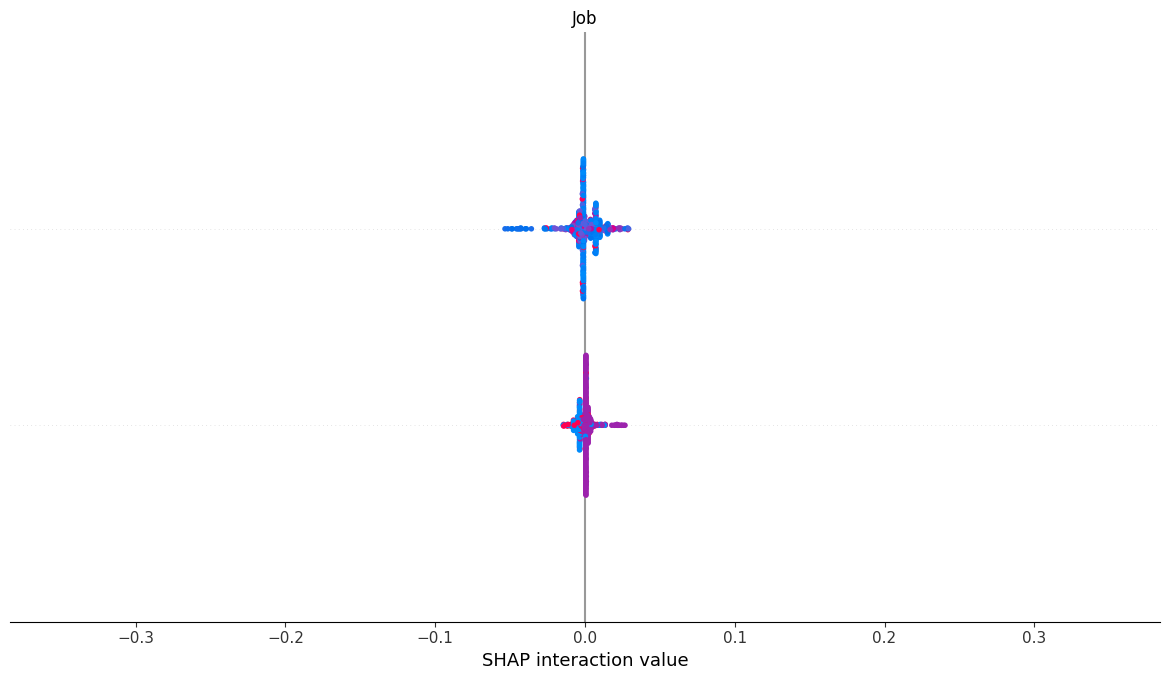

In [ ]:
# # SHAP values for model interpretation (if tree-based model)

preprocessor = best_model.named_steps['preprocessor']

# 2. Extract feature names after preprocessing
from sklearn.compose import ColumnTransformer

def get_feature_names(preprocessor):
    output_features = []
    for name, transformer, cols in preprocessor.transformers_:
        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(cols)
        else:
            names = cols
        output_features.extend(names)
    return output_features

preprocessed_feature_names = get_feature_names(preprocessor)

# 3. Select only the features retained by feature selection
support_mask = best_model.named_steps['feature_selection'].get_support()
selected_feature_names = [name for i, name in enumerate(preprocessed_feature_names) if support_mask[i]]


# SHAP interpretation
explainer = shap.Explainer(best_model.named_steps['classifier'], selected_X_train)
shap_values = explainer(selected_X_train)

shap.summary_plot(shap_values, selected_X_train, feature_names=selected_feature_names, plot_type="bar")



In [12]:
# Insights and Recommendations
print("\nKey Insights and Recommendations:")
print("1. The most important features for credit risk prediction are:")
for i, row in feature_importance.head(5).iterrows():
    print(f"   - {row['Feature']} (importance: {row['Importance']:.3f})")

print("\n2. The model achieved good performance with an ROC AUC score of", 
      f"{roc_auc_score(y_test, y_proba):.2f}, indicating strong predictive power.")

print("\n3. Recommendations for credit evaluation process:")
print("   - Pay special attention to applicants with high credit amounts and long durations")
print("   - Consider implementing automated risk scoring based on these key features")
print("   - Regularly update the model with new data to maintain accuracy")
print("   - Use the model's probabilities to set different interest rates based on risk levels")

# Save the model (optional)
import joblib
joblib.dump(best_model, 'credit_risk_model.pkl')


Key Insights and Recommendations:
1. The most important features for credit risk prediction are:
   - Duration (importance: 0.554)
   - Credit amount (importance: 0.428)
   - Job (importance: 0.009)
   - Housing_free (importance: 0.005)
   - Purpose_business (importance: 0.004)

2. The model achieved good performance with an ROC AUC score of 1.00, indicating strong predictive power.

3. Recommendations for credit evaluation process:
   - Pay special attention to applicants with high credit amounts and long durations
   - Consider implementing automated risk scoring based on these key features
   - Regularly update the model with new data to maintain accuracy
   - Use the model's probabilities to set different interest rates based on risk levels


['credit_risk_model.pkl']